In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=[10., 6.]
from cStringIO import StringIO
import matplotlib.dates as mdates

from math import factorial#, log10
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range]
                      for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

class acquisition:
    sep = {"MISE EN TEMPERATURE":None, "MISE EN CHARGE":None, "FLUAGE":None}
    def __init__(self, *source):
        def _prepare(_f, _fn):
            while True:
                _ln = _f.readline()
                if _ln=='': break
                _curln = _ln.rstrip()
                if _curln in self.sep:
                    _cur = _curln
                    self.sep[_cur] = [np.array([
                        _f.readline().rstrip().split('\t'), 
                        _f.readline().rstrip().split('\t')]),
                        StringIO()]
                    _ln = _f.readline()
                self.sep[_cur][1].write(_ln)
            _f.close()
            for _ in self.sep:
                self.sep[_][1].seek(0)
                self.sep[_][1] = np.loadtxt(self.sep[_][1], delimiter='\t', converters={0: mdates.strpdate2num("%Y/%m/%d %H:%M:%S.%f")})
            print _fn;
        #
        if len(source):
            _prepare(open(source[0], "r"), "File '%s' readed successfully!" % source[0])
        else:
            from IPython.display import display
            import fileupload 
            cS = None
            def _cbk(change):
                _prepare(StringIO(change['new']), "File '%s' uploaded successfully!" % change['owner'].filename)
            #
            _upload_widget = fileupload.FileUploadWidget()
            _upload_widget.observe(_cbk, names='data')
            display(_upload_widget)
        
    
    #part1. MISE EN TEMPERATURE:
    def chauffage_temperature(self):
        #0_chauffage_temperature.png      $3*60        $4, $5, $6, ($4+$5+$6)/3
        ME = self.sep['MISE EN TEMPERATURE'][1]
        TMP = "Temperature "
        X,Y1,Y2,Y3 = ME[:,1],ME[:,2],ME[:,3],ME[:,4]
        plt.title('Mise en temperature')
        plt.plot(X,Y1,'b+',label=TMP+'1');
        plt.plot(X,Y2,'g+',label=TMP+'2');
        plt.plot(X,Y3,'r+',label=TMP+'3');
        plt.plot(X,(Y1+Y2+Y3)/3.,'k-',label=TMP+'moyen')
        plt.legend(loc='lower right')        
        plt.show()
        plt.title('Mise en temperature[ZOOM]')
        plt.plot(X,Y1,'b+',label=TMP+'1');
        plt.plot(X,Y2,'g+',label=TMP+'2');
        plt.plot(X,Y3,'r+',label=TMP+'3');
        plt.plot(X,(Y1+Y2+Y3)/3.,'k-',label=TMP+'moyen')
        plt.axis([700., 1000., 490., 500.])
        plt.show()
    
    #part2. MISE EN CHARGE:
    def charge_allongement(self):
        #1_charge_allongement.png            $5        $6/100, $7/100, ($6+$7)/200  
        AL = 'Allongement '
        ME = self.sep['MISE EN CHARGE'][1]
        X,Y1,Y2 = ME[:,3], ME[:,4]/100., ME[:,5]/100.
        plt.title('Mise en charge')
        plt.plot(X,Y1,'b+',label=AL+'1');
        plt.plot(X,Y2,'r+',label=AL+'2');
        plt.plot(X,(Y1+Y2) / 2.,'k-',label=AL+'moyen')
        plt.legend(loc='upper left')
        plt.show()
    def charge_contrainte(self):
        #1_charge_contrainte.png             $5        $4
        ME = self.sep['MISE EN CHARGE'][1]
        plt.title('Mise en charge')
        plt.plot(ME[:,3], ME[:,2])
        plt.show()
    def charge_temperature(self):
        #1_charge_temperature.png            $5        $8, $9, $10, ($8+$9+$10)/3
        ME = self.sep['MISE EN CHARGE'][1]
        TMP = "Temperature "
        X,Y1,Y2,Y3 = ME[:,3],ME[:,6],ME[:,7],ME[:,8]
        plt.title('Mise en charge')
        plt.plot(X,Y1,'b+',label=TMP+'1');
        plt.plot(X,Y2,'g+',label=TMP+'2');
        plt.plot(X,Y3,'r+',label=TMP+'3');
        plt.plot(X,(Y1+Y2+Y3)/3.,'k-',label=TMP+'moyenne')
        plt.axis([-9., 0., 490., 500.])
        plt.legend(loc='lower right')
        plt.show()        
    
    #part3. FLUAGE:
    def fluage_allongement(self):
        #fluage_allongement.png            $5        $6/100, $7/100, ($6+$7)/200
        AL = 'Allongement '
        ME = self.sep['FLUAGE'][1]
        X = ME[:,3]
        Y1 = savitzky_golay(ME[:,4], window_size=61, order=4) / 100.
        Y2 = savitzky_golay(ME[:,5], window_size=61, order=4) / 100.
        plt.title('Fluage')
        plt.plot(X,Y1,'b+',label=AL+'1');
        plt.plot(X, Y2,'r+',label=AL+'2');
        plt.plot(X, (Y1+Y2)/ 2.,'k-',label=AL+'moyen')
        plt.legend(loc='lower right')
        plt.show()
    def fluage_allongement_moy(self):
        #2_fluage_allongement_moy.png        $5        ($6+$7)/200    
        ME = self.sep['FLUAGE'][1]
        X = ME[:,3]
        Y1 = savitzky_golay(ME[:,4], window_size=61, order=4) / 100.
        Y2 = savitzky_golay(ME[:,5], window_size=61, order=4) / 100.
        plt.title('Fluage')
        plt.plot(X, (Y1+Y2)/ 2.,'k-')
        plt.show()
    def fluage_temperature(self):
        #2_fluage_temperature.png            $5        $8, $9, $10, ($8+$9+$10)/3
        TMP = "Temperature "
        ME = self.sep['FLUAGE'][1]
        X,Y1,Y2,Y3 = ME[:,3],ME[:,6],ME[:,7],ME[:,8]
        plt.title('Fluage')
        plt.plot(X,Y1,'b+',label=TMP+'1'); 
        plt.plot(X,Y2,'g+',label=TMP+'2'); 
        plt.plot(X,Y2,'r+',label=TMP+'3');
        plt.plot(X, (Y1+Y2+Y3 ) / 3.,'k-',label=TMP + 'moyen')
        plt.axis([0., 1000., 490., 501.])
        plt.legend(loc='lower right')
        plt.show()
    def fluage_vitesse_moy(self):
        #2_fluage_vitesse_moy.png            $5        ($6+$7)/200        vitesse de fluage (???) 
        # + filter + dy/dx
        X,Y1,Y2 = acc.columns("FLUAGE", 3,4,5)
        Y= 0.5*(Y1+Y2)
        Ys = savitzky_golay(Y,21,1,deriv=0,rate=1)#???21,1,deriv=0,rate=1

        dX,dY=[],[]
        step=40;    cutoff=200;    cutoff_s=10    
        for j in range(len(Ys)-step-cutoff-cutoff_s):
            dY.append((Ys[j+step+cutoff_s]-Ys[j+cutoff_s])/(X[j+step+cutoff_s]-X[j+cutoff_s]))
            dX.append(X[j+step+cutoff_s])
        dY_s=savitzky_golay(dY,11,1,deriv=0,rate=1)*0.01
        plt.semilogy(dX,dY_s,label='fluage_vitesse_moy')
        plt.ylim(1e-10,1e-4);
        plt.title('Fluage')
        plt.legend()
        plt.show()        
    
    #more methodes:
    def columns(self,part,*lst):
        return map(lambda x: self.sep[part][1][:,x],lst)
        

In [7]:
#чтение данных из файла на хосте СЕРВЕРА
acc = acquisition('/notebooks/arinas/2017_02_08/2267.acquisition')

File '/notebooks/arinas/2017_02_08/2267.acquisition' readed successfully!


In [8]:
#загрузка данных из файла на хосте КЛИЕНТА
acc = acquisition()

File '2267.acquisition' uploaded successfully!


## part1. MISE EN TEMPERATURE:

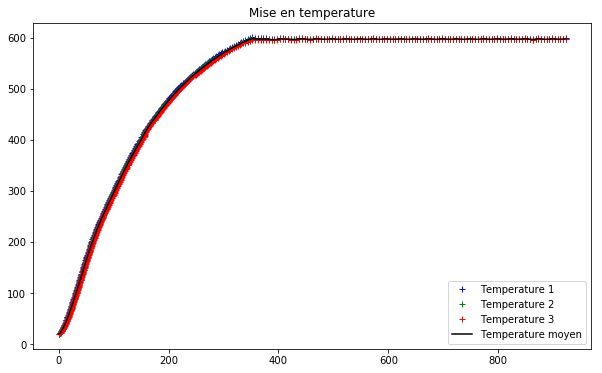

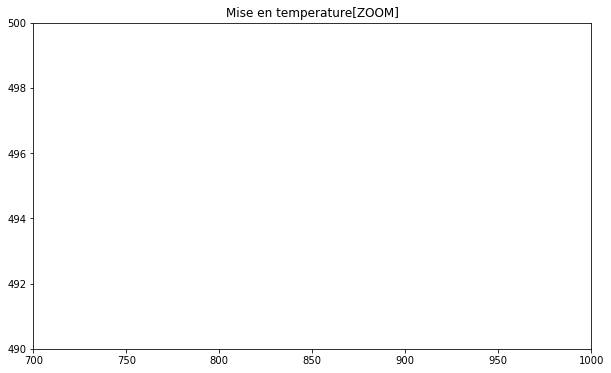

In [9]:
acc.chauffage_temperature()

## part2. MISE EN CHARGE:

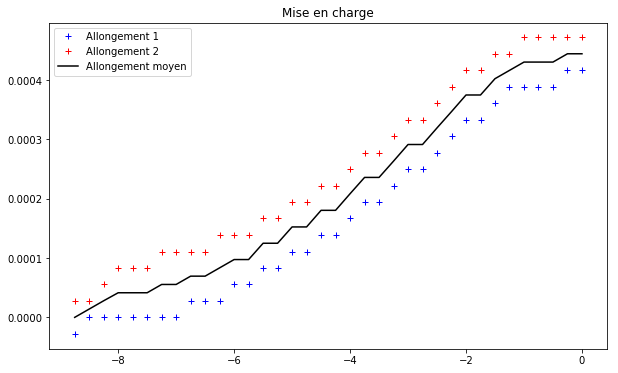

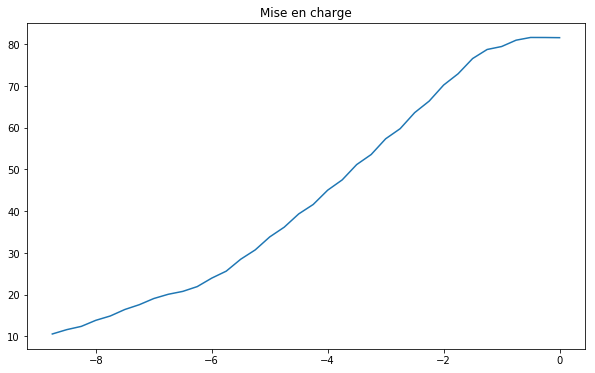

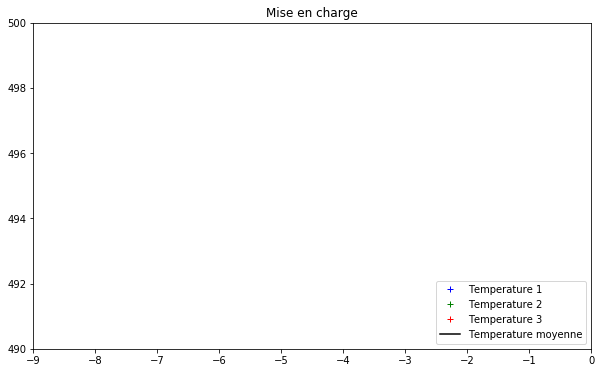

In [10]:
acc.charge_allongement()
acc.charge_contrainte()
acc.charge_temperature()

## part3. FLUAGE:

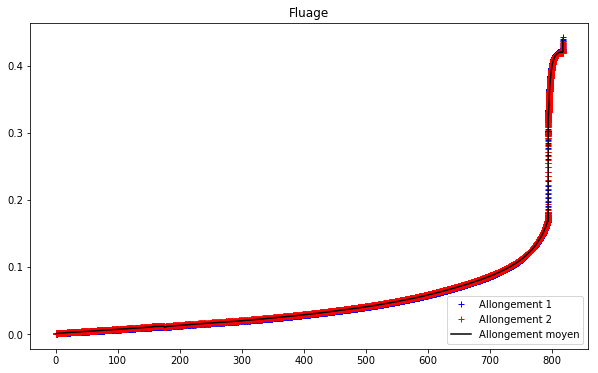

In [11]:
acc.fluage_allongement()

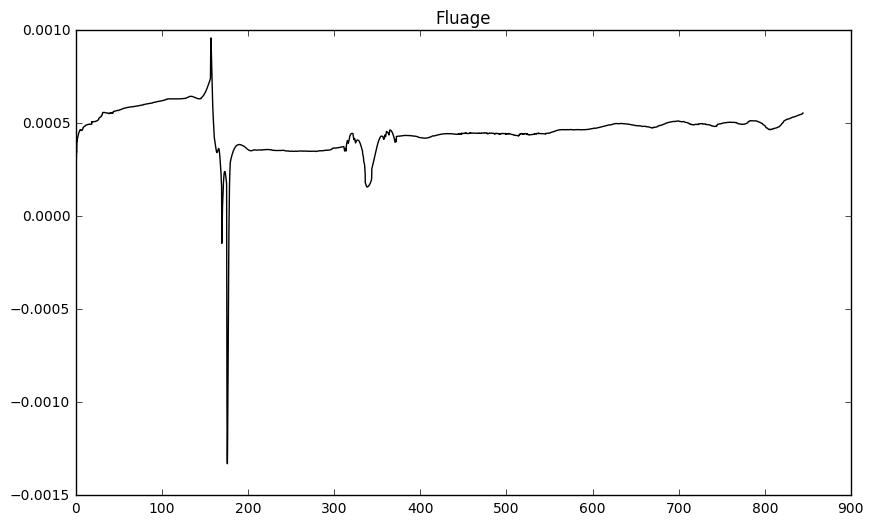

In [37]:
acc.fluage_allongement_moy()

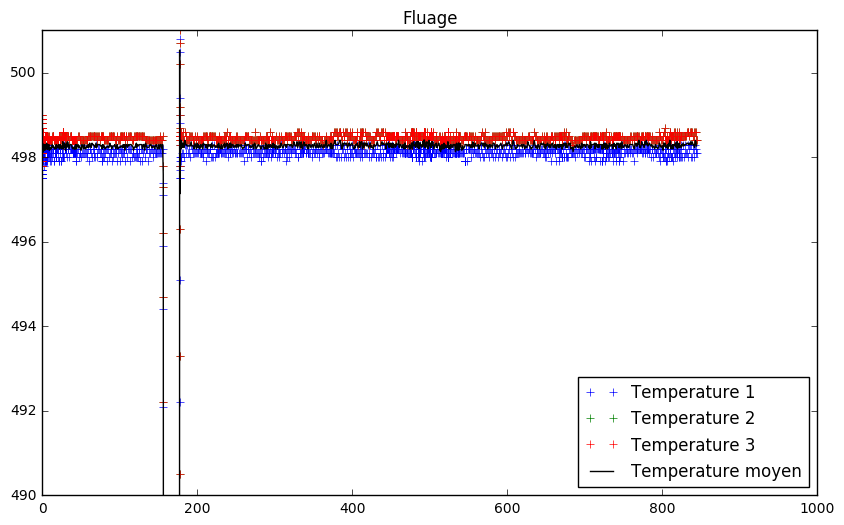

In [38]:
acc.fluage_temperature()

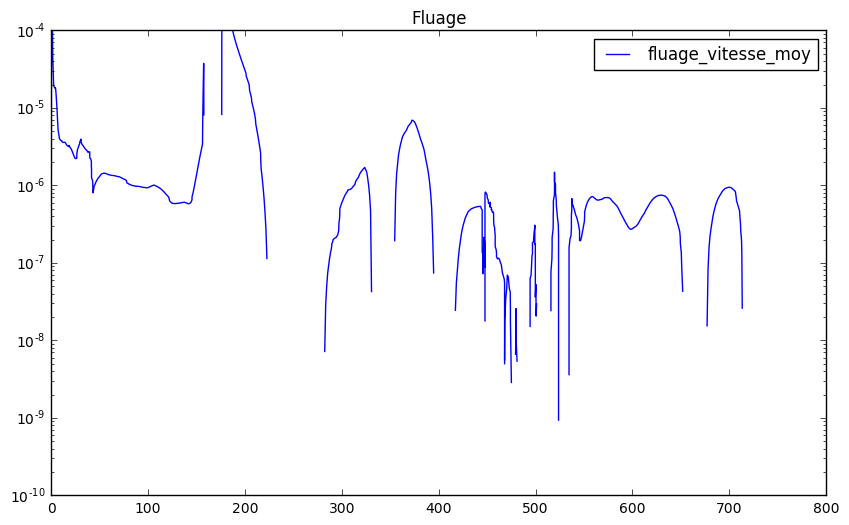

In [99]:
acc.fluage_vitesse_moy()

### 2_fluage_vitesse_moy.png            5        (6+7)/200        vitesse de fluage (???) + filter + dy/dx
**sandbox**

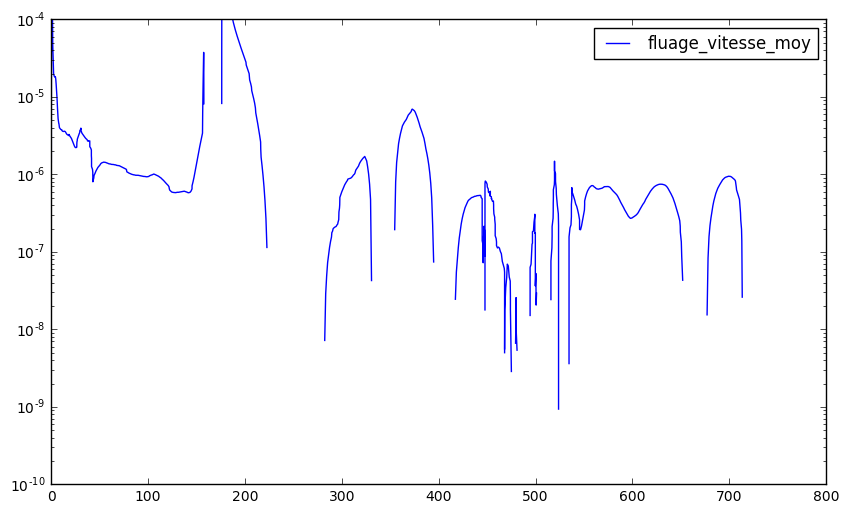

In [96]:
X,Y1,Y2 = acc.columns("FLUAGE", 3,4,5)
Y= 0.5*(Y1+Y2)
Ys = savitzky_golay(Y,21,1,deriv=0,rate=1)#???21,1,deriv=0,rate=1

dX,dY=[],[]
step=40;    cutoff=200;    cutoff_s=10    
#step=40;    cutoff=0;    cutoff_s=0

for j in range(len(Ys)-step-cutoff-cutoff_s):
    dY.append((Ys[j+step+cutoff_s]-Ys[j+cutoff_s])/(X[j+step+cutoff_s]-X[j+cutoff_s]))
    dX.append(X[j+step+cutoff_s])
dY_s=savitzky_golay(dY,11,1,deriv=0,rate=1)*0.01
plt.semilogy(dX,dY_s,label='fluage_vitesse_moy')
plt.ylim(1e-10,1e-4);
plt.legend()
plt.show()


----------------------
# from acquisition import acquisition

In [107]:
!ls *.py

acquisition.py	DeriveCreep.py	fluage_post_acquisition.py  post_resu.py


In [12]:
from acquisition import acquisition
acq = acquisition()

File '2267.acquisition' uploaded successfully!


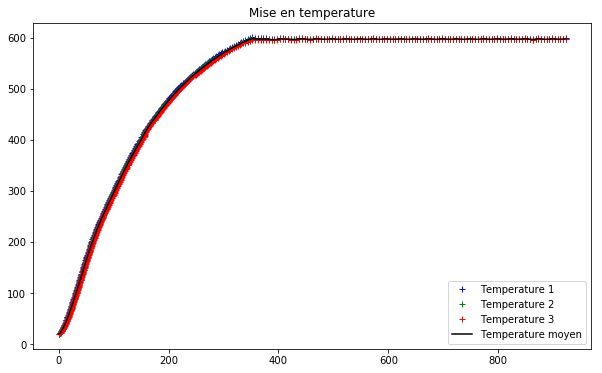

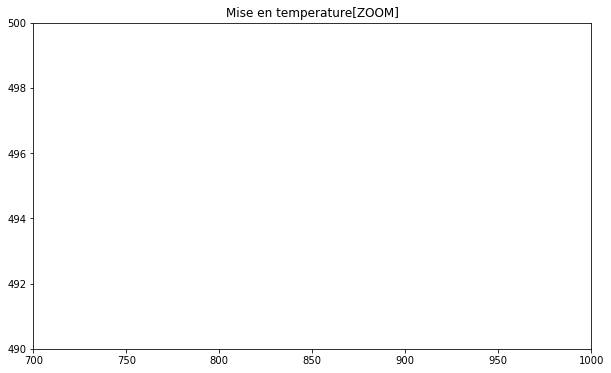

In [14]:
acq.chauffage_temperature()